In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [2]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

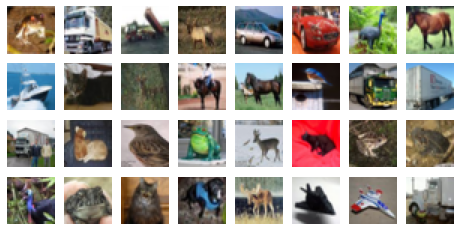

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

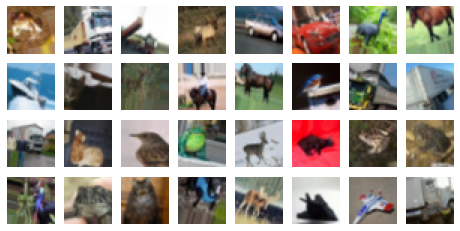

In [7]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

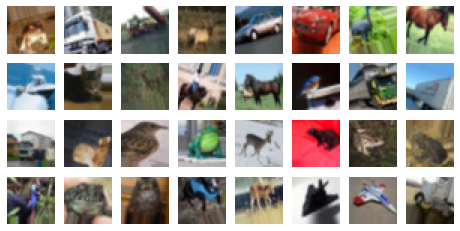

In [9]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
#左右相反了
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [3]:
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

In [4]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

In [78]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train_samples')
print(x_test.shape[0], 'test_samples')

x_train shape: (50000, 32, 32, 3)
50000 train_samples
10000 test_samples


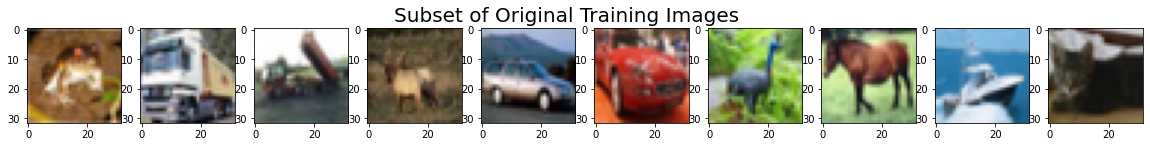

In [79]:
import matplotlib.pyplot as plt

num_to_view = 10

# take subset of training data
x_train_subset = x_train[:num_to_view]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, num_to_view, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

In [85]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
augment_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

augment_generator.fit(x_train)


## 看一下有沒有增加資料了 (圖片反過來了)

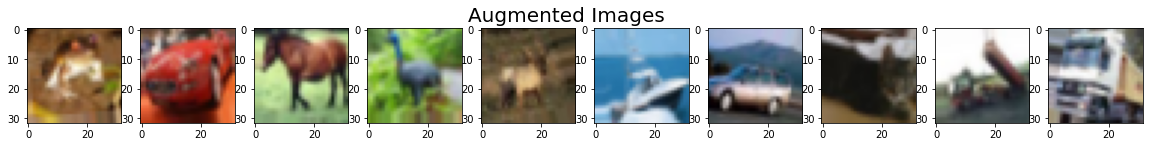

In [87]:
# visualize augmented images
import numpy as np
fig = plt.figure(figsize=(20,2))
for x_batch in augment_generator.flow(x_train_subset, batch_size=12):
    for i in range(0, num_to_view):
        ax = fig.add_subplot(1, num_to_view, i+1)
        ax.imshow(x_batch[i].astype(np.uint8))
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [88]:
##reshape into images
img_rows, img_cols , channels= 32,32,3
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [89]:
#convert integers to float; normalise and center the mean
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = x_train.shape[1:])) #x_train.shape[1:] 32 x 32 x 3
model.add(Activation('relu'))
model.add(Conv2D(32,(3, 3)))  # (32-3+1) x (32-3+1) = 30 x 30
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2))) # 30/2 x 30/2 = 15 x 15
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding= 'same')) 
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3))) # 15-3+1 x 15-3+1 = 13 x 13
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2, 2))) # 13/2 x 13/2 = 6 x 6
model.add(Dropout(0.25))


#攤平 要放入全連階層了
model.add(Flatten()) # 6 x 6 x 64
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))  # 10個分類
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [91]:
from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit_generator(augment_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10


C:\Users\huang\AppData\Local\Temp/ipykernel_5464/2447686520.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augment_generator.flow(x_train, y_train, batch_size=batch_size),


390/390 [==============================] - ETA: 0s - loss: 1.8173 - accuracy: 0.3399
Epoch 1: val_loss improved from inf to 1.33528, saving model to aug_model.weights.best.hdf5
390/390 [==============================] - 49s 125ms/step - loss: 1.8173 - accuracy: 0.3399 - val_loss: 1.3353 - val_accuracy: 0.5198
Epoch 2/10
390/390 [==============================] - ETA: 0s - loss: 1.4354 - accuracy: 0.4847
Epoch 2: val_loss improved from 1.33528 to 1.21188, saving model to aug_model.weights.best.hdf5
390/390 [==============================] - 48s 124ms/step - loss: 1.4354 - accuracy: 0.4847 - val_loss: 1.2119 - val_accuracy: 0.5682
Epoch 3/10
390/390 [==============================] - ETA: 0s - loss: 1.2764 - accuracy: 0.5463
Epoch 3: val_loss improved from 1.21188 to 1.07694, saving model to aug_model.weights.best.hdf5
390/390 [==============================] - 48s 124ms/step - loss: 1.2764 - accuracy: 0.5463 - val_loss: 1.0769 - val_accuracy: 0.6196
Epoch 4/10
390/390 [=================

In [92]:
model.save('final_model_CNN_with_Augmentation.h5')

#  沒有做資料增強的結果

In [20]:
history_nope = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,  
                    verbose=1,
                    validation_data=(x_test, y_test))
score_nope = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_nope[0])
print('Test accuracy:', score_nope[1])

Epoch 1/10
391/391 [==============================] - 46s 116ms/step - loss: 0.7582 - accuracy: 0.7369 - val_loss: 0.7915 - val_accuracy: 0.7373
Epoch 2/10
391/391 [==============================] - 48s 122ms/step - loss: 0.7141 - accuracy: 0.7542 - val_loss: 0.7187 - val_accuracy: 0.7637
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.6926 - accuracy: 0.7615 - val_loss: 0.6498 - val_accuracy: 0.7767
Epoch 4/10
391/391 [==============================] - 46s 118ms/step - loss: 0.6630 - accuracy: 0.7715 - val_loss: 0.6595 - val_accuracy: 0.7885
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.6538 - accuracy: 0.7773 - val_loss: 0.6442 - val_accuracy: 0.7873
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.6354 - accuracy: 0.7857 - val_loss: 0.6251 - val_accuracy: 0.7892
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.6314 - accuracy: 0.7860 - val_loss: 0.7219 - val_ac

似乎做了資料增強沒有比較好

## 查看一下模型預測結果

In [8]:
model = keras.models.load_model('final_model_CNN_with_Augmentation.h5')

In [10]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

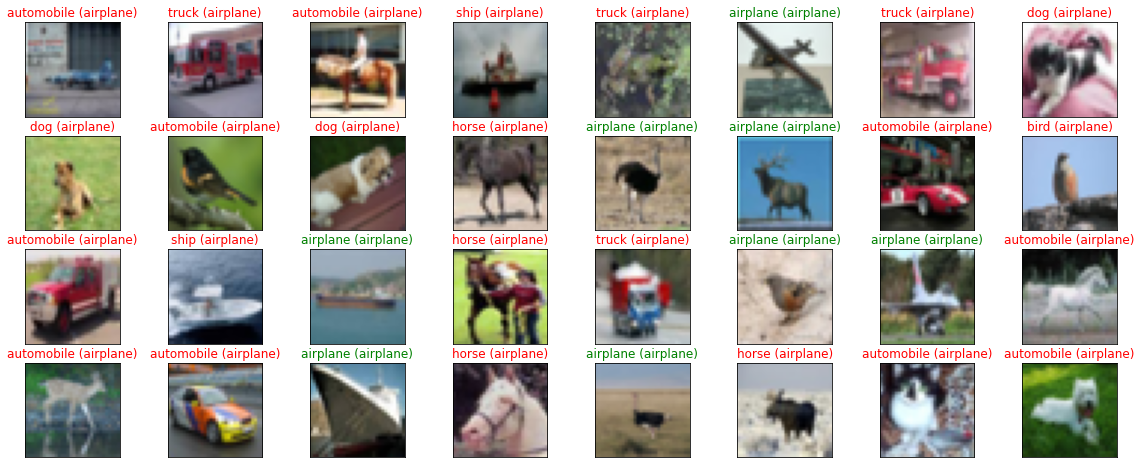

In [13]:
# plot a random sample of test images, their predicted labels, and ground truth
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))